In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616]),
        transforms.RandomErasing(p=0.75,
                                 scale=(0.01, 0.3),
                                 ratio=(1.0, 1.0),
                                 value=0,
                                 inplace =True)
    ])

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], 
                             [0.2470, 0.2435, 0.2616])
    ])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=val_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=10
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
# Load the pretrained VGG16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
f_extractor = vgg16.features

# Freeze the first five layers
layer_count = 0
for child in f_extractor.children():
    if layer_count < 10:
        for param in child.parameters():
            param.requires_grad = False
    layer_count += 1

for name, module in f_extractor.named_modules():
    if hasattr(module, 'parameters'):
        is_trainable = any(param.requires_grad for param in module.parameters())
        print(f"{name}: {'Trainable' if is_trainable else 'Not trainable'}")

: Trainable
0: Not trainable
1: Not trainable
2: Not trainable
3: Not trainable
4: Not trainable
5: Not trainable
6: Not trainable
7: Not trainable
8: Not trainable
9: Not trainable
10: Trainable
11: Not trainable
12: Trainable
13: Not trainable
14: Trainable
15: Not trainable
16: Not trainable
17: Trainable
18: Not trainable
19: Trainable
20: Not trainable
21: Trainable
22: Not trainable
23: Not trainable
24: Trainable
25: Not trainable
26: Trainable
27: Not trainable
28: Trainable
29: Not trainable
30: Not trainable


In [4]:
model = nn.Sequential(f_extractor, 
                      nn.Flatten(), 
                      nn.Dropout(), 
                      nn.Linear(512, 10))
model.to(device)
summary(model, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          (1,792)
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          (36,928)
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         (73,856)
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         (147,584)
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          (1,792)
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          (36,928)
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         (73,856)
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         (147,584)
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-5)  

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 1.8029, Accuracy: 36.09%, Test Loss: 0.9816, Test Accuracy: 66.79%
Epoch [2/100], Loss: 1.1030, Accuracy: 61.91%, Test Loss: 0.7424, Test Accuracy: 74.66%
Epoch [3/100], Loss: 0.9282, Accuracy: 68.39%, Test Loss: 0.6661, Test Accuracy: 77.04%
Epoch [4/100], Loss: 0.8408, Accuracy: 71.34%, Test Loss: 0.6157, Test Accuracy: 78.91%
Epoch [5/100], Loss: 0.7745, Accuracy: 73.41%, Test Loss: 0.5706, Test Accuracy: 80.46%
Epoch [6/100], Loss: 0.7229, Accuracy: 75.18%, Test Loss: 0.5441, Test Accuracy: 81.55%
Epoch [7/100], Loss: 0.6880, Accuracy: 76.62%, Test Loss: 0.5173, Test Accuracy: 82.21%
Epoch [8/100], Loss: 0.6532, Accuracy: 77.58%, Test Loss: 0.5052, Test Accuracy: 82.96%
Epoch [9/100], Loss: 0.6202, Accuracy: 78.68%, Test Loss: 0.4813, Test Accuracy: 83.43%
Epoch [10/100], Loss: 0.5995, Accuracy: 79.52%, Test Loss: 0.4788, Test Accuracy: 83.63%
Epoch [11/100], Loss: 0.5735, Accuracy: 80.22%, Test Loss: 0.4566, Test Accuracy: 84.43%
Epoch [12/100], Loss: 0.5506, 

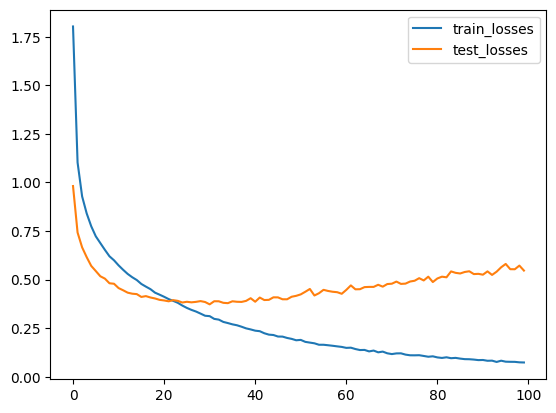

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

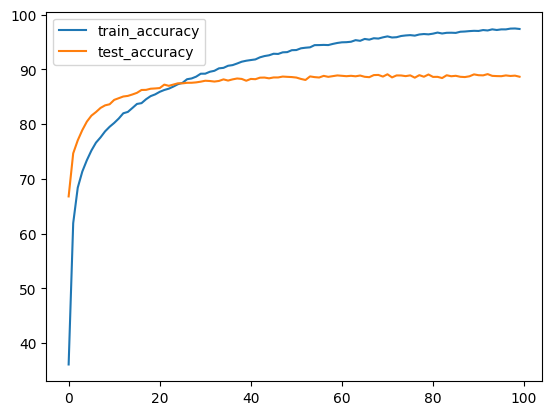

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()